In [1]:

import xml.etree.ElementTree as ET
import networkx as nx
from rich import print

def parse_xml_to_graph(xml_data):
    # Parse the XML data
    root = ET.fromstring(xml_data)
    
    # Create a new graph
    G = nx.Graph()

    # Iterate over each vertex in the XML
    for i, vertex in enumerate(root.find('graph').findall('vertex')):
        source = str(i)  # Using the index as the vertex ID, converted to string
        # Iterate over each edge for this vertex
        for edge in vertex.findall('edge'):
            target = edge.text
            cost = float(edge.get('cost'))
            # Add an edge to the graph
            G.add_edge(source, target, weight=cost)

    return G

xml_data = open('brazil58.xml').read()
# xml_data = open('burma14.xml').read()

# Parse the XML and create the graph
graph = parse_xml_to_graph(xml_data)


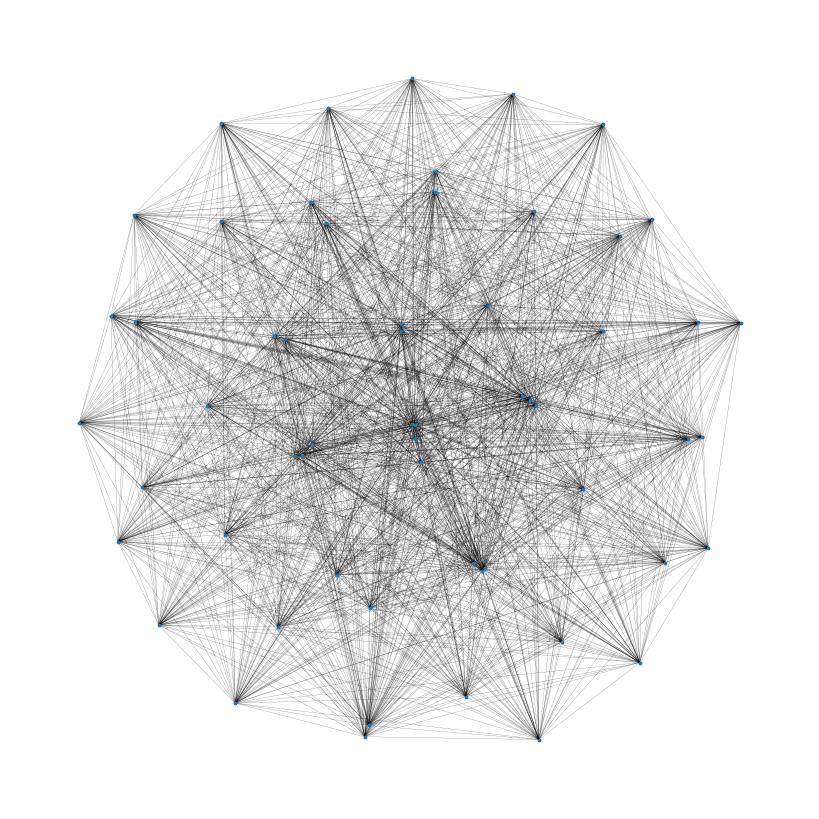

In [2]:
# output the graph using matplotlib
import matplotlib.pyplot as plt
width = 8
plt.figure(figsize=(width, width))
layout = nx.spring_layout(graph, seed=3, k = .5, iterations=2000)
nx.draw(graph, with_labels=False, node_size=3, width=0.1, pos=layout)

In [6]:
import random
from tqdm import tqdm

class AntColonyOptimizer:
    def __init__(self, graph, num_ants, evaporation_rate, alpha, beta, max_iterations, show_progress_bar = True):
        self.graph = graph
        self.num_ants = num_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha
        self.beta = beta
        self.max_iterations = max_iterations
        self.show_progress_bar = show_progress_bar
        

    def initialize_pheromones(self):
        # Initialize pheromones on the edges
        for u, v in self.graph.edges():
            self.graph[u][v]['pheromone'] = random.uniform(0, 1)

    def run(self):
        self.initialize_pheromones()
        best_cost = float('inf')
        best_solution = None
        
        if self.show_progress_bar:
            r = tqdm(range(self.max_iterations), desc="Iterations", colour='green')
        else:
            r = range(self.max_iterations)

        # Main loop with tqdm progress bar
        for iteration in r:
            paths = []  # List to store paths and costs for this iteration
            for ant in range(self.num_ants):
                solution, cost = self.generate_solution()
                paths.append((solution, cost))  # Add the path and its cost
                if cost < best_cost:
                    best_cost = cost
                    best_solution = solution

            # Update pheromones with the collected paths
            self.update_pheromones(paths)

            # Evaporate pheromones
            self.evaporate_pheromones()

        return best_solution, best_cost


    def generate_solution(self):
        path = []
        visited = set()
        current_city = random.choice(list(self.graph.nodes))
        path.append(current_city)
        visited.add(current_city)

        while len(visited) < len(self.graph.nodes):
            probabilities = self.calculate_transition_probabilities(current_city, visited)
            next_city = self.select_next_city(probabilities)
            path.append(next_city)
            visited.add(next_city)
            current_city = next_city

        return path, self.calculate_path_cost(path)

    def calculate_transition_probabilities(self, current_city, visited):
        probabilities = {}
        denominator = sum((self.graph[current_city][neighbor]['pheromone'] ** self.alpha) *
                        ((1 / self.graph[current_city][neighbor]['weight']) ** self.beta)
                        for neighbor in self.graph.neighbors(current_city) if neighbor not in visited)

        for neighbor in self.graph.neighbors(current_city):
            if neighbor not in visited:
                probabilities[neighbor] = ((self.graph[current_city][neighbor]['pheromone'] ** self.alpha) *
                                        ((1 / self.graph[current_city][neighbor]['weight']) ** self.beta)) / denominator
        return probabilities

    def select_next_city(self, probabilities):
        return max(probabilities, key=probabilities.get)

    def calculate_path_cost(self, path):
        cost = 0
        for i in range(len(path) - 1):
            cost += self.graph[path[i]][path[i + 1]]['weight']
        cost += self.graph[path[-1]][path[0]]['weight']  # Return to start
        return cost


    def update_pheromones(self, paths):
        for path, cost in paths:
            deposit_amount = 1.0 / cost  # For example, can vary based on your problem specifics
            for i in range(len(path) - 1):
                self.graph[path[i]][path[i + 1]]['pheromone'] += deposit_amount


    def evaporate_pheromones(self):
        for u, v in self.graph.edges():
            self.graph[u][v]['pheromone'] *= (1 - self.evaporation_rate)


aco = AntColonyOptimizer(graph, num_ants=10, evaporation_rate=0.5, alpha=1, beta=2, max_iterations=200, show_progress_bar=True)
best_solution, best_cost = aco.run()

Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Iterations: 100%|██████████| 200/200 [00:07<00:00, 25.84it/s]


In [11]:
import itertools
import networkx as nx
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures

# Define the ranges for each parameter
num_ants_options = [10, 20, 30]
evaporation_rate_options = [0.1, 0.3, 0.5, 0.7, 0.9]
alpha_options = [1, 2, 3]
beta_options = [1, 2, 3]
max_iterations_options = [50, 100, 150, 200, 250]

# Create a cartesian product of all parameter options
parameter_combinations = list(itertools.product(
    num_ants_options,
    evaporation_rate_options,
    alpha_options,
    beta_options,
    max_iterations_options
))

# Placeholder for the best parameter set and its associated cost
best_params = None
best_solution = None
best_cost = float('inf')

# Function to run an individual experiment
def run_experiment(params):
    num_ants, evap_rate, alpha, beta, max_iter = params
    aco = AntColonyOptimizer(graph, num_ants, evap_rate, alpha, beta, max_iter, show_progress_bar=False)
    solution, cost = aco.run()
    return cost, params, solution

# Running experiments in parallel
best_cost = float('inf')
best_params = None
best_solution = None

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(run_experiment, params) for params in parameter_combinations]

    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Grid Search", unit="comb", colour='green'):
        cost, params, solution = future.result()
        if cost < best_cost:
            best_cost = cost
            best_params = params
            best_solution = solution

print(f"Best parameters found: {best_params} with cost: {best_cost}")


/tmp/ipykernel_560734/2096514180.py:73: RuntimeWarning: invalid value encountered in divide
  probabilities /= probabilities.sum()  # Normalize
/tmp/ipykernel_560734/2096514180.py:73: RuntimeWarning: invalid value encountered in divide
  probabilities /= probabilities.sum()  # Normalize
Grid Search:   0%|          | 0/675 [00:00<?, ?comb/s]/tmp/ipykernel_560734/2096514180.py:73: RuntimeWarning: invalid value encountered in divide
  probabilities /= probabilities.sum()  # Normalize
/tmp/ipykernel_560734/2096514180.py:73: RuntimeWarning: invalid value encountered in divide
  probabilities /= probabilities.sum()  # Normalize
/tmp/ipykernel_560734/2096514180.py:73: RuntimeWarning: invalid value encountered in divide
  probabilities /= probabilities.sum()  # Normalize
/tmp/ipykernel_560734/2096514180.py:73: RuntimeWarning: invalid value encountered in divide
  probabilities /= probabilities.sum()  # Normalize
/tmp/ipykernel_560734/2096514180.py:73: RuntimeWarning: invalid value encountered 

/tmp/ipykernel_560734/2096514180.py:73: RuntimeWarning: invalid value encountered in divide
  probabilities /= probabilities.sum()  # Normalize
/tmp/ipykernel_560734/2096514180.py:73: RuntimeWarning: invalid value encountered in divide
  probabilities /= probabilities.sum()  # Normalize
Grid Search:  30%|██▉       | 202/675 [02:16<05:20,  1.48comb/s]


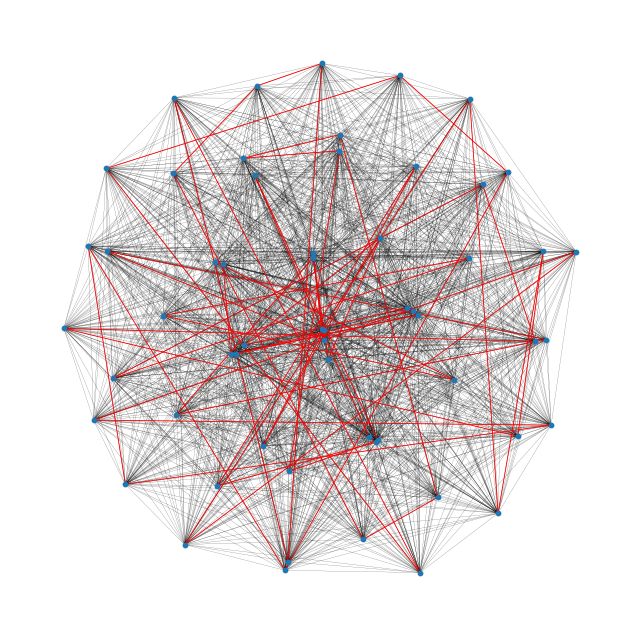

In [7]:
def draw_best_path(graph, best_path, pos):
    plt.figure(figsize=(width, width))

    # Draw the graph
    nx.draw_networkx_nodes(graph, pos, node_size=10)
    # nx.draw_networkx_labels(graph, pos)
    nx.draw_networkx_edges(graph, pos, edgelist=graph.edges, width=0.1)

    # Extract edges from the path
    path_edges = [(best_path[i], best_path[i+1]) for i in range(len(best_path) - 1)]
    path_edges.append((best_path[-1], best_path[0]))  # Adding edge to complete the tour

    # Draw the path edges
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='red', width=.6)

    plt.axis('off')
    plt.show()

# Assuming 'graph' is your NetworkX graph and 'best_solution' is the best path found
draw_best_path(graph, best_solution, layout)


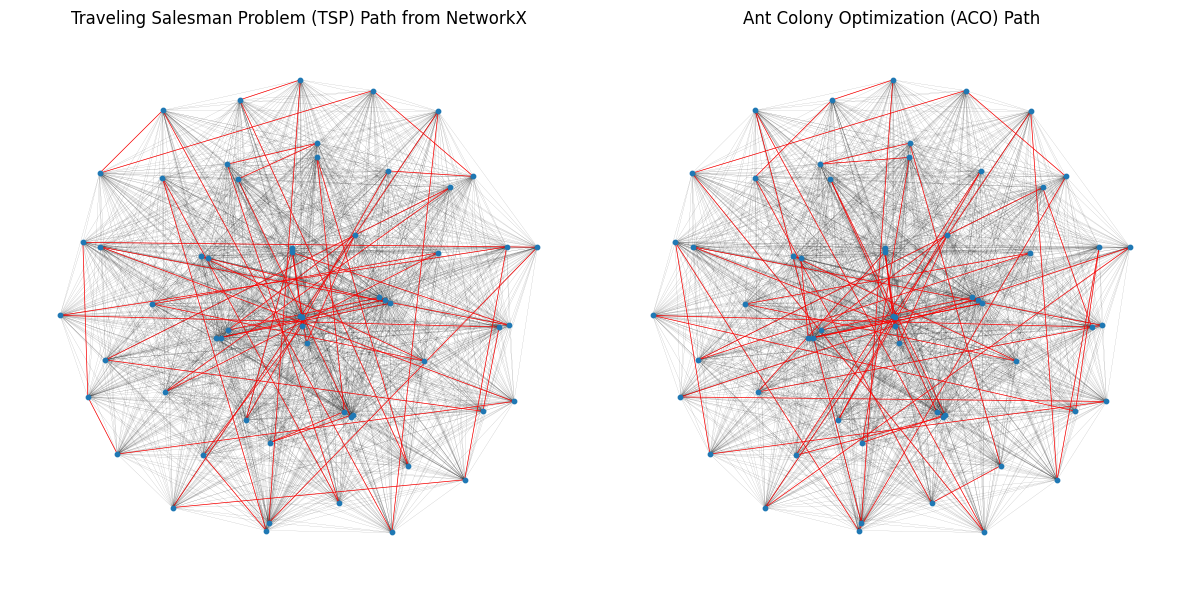

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))


# Extract edges from the ACO path
path_edges = [(best_solution[i], best_solution[i+1]) for i in range(len(best_solution) - 1)]
path_edges.append((best_solution[-1], best_solution[0]))  # Adding edge to complete the tour

# Draw TSP path on the left subplot

import networkx.algorithms.approximation as nx_app
cycle = nx_app.christofides(graph, weight="weight")

edge_list = list(nx.utils.pairwise(cycle))
# Combine the two lists into a single networkx graph
tsp_g = nx.Graph()
tsp_g.add_nodes_from(graph.nodes)
tsp_g.add_edges_from(edge_list)

ax1.set_title('Traveling Salesman Problem (TSP) Path from NetworkX')
nx.draw_networkx_nodes(graph, pos=layout, node_size=10, ax=ax1)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.05, ax=ax1)
nx.draw_networkx_edges(tsp_g, pos=layout, width=0.5, edge_color='red', ax=ax1)
ax1.axis('off')

# Draw ACO path on the right subplot
ax2.set_title('Ant Colony Optimization (ACO) Path')
nx.draw_networkx_nodes(graph, pos=layout, node_size=10, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=graph.edges, width=0.05, ax=ax2)
nx.draw_networkx_edges(graph, pos=layout, edgelist=path_edges, width=0.5, edge_color='red', ax=ax2)
ax2.axis('off')



# Adjust layout and display the figure
plt.tight_layout()
plt.show()


In [9]:
# Weight of the TSP path found by NetworkX, use the weights of the edges from the original graph
tsp_cost = sum(graph[u][v]['weight'] for u, v in edge_list)
print(f"Cost of TSP Path with NetworkX: {tsp_cost}")


# Weight of the best path found by the ACO algorithm
print(f"Cost of Best Path with ACO: {best_cost}")

Cost of TSP Path with NetworkX: 27442.0

Cost of Best Path with ACO: 28634.0